In [41]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import date, timedelta
from scipy.stats import skew, kurtosis
import matplotlib.dates as mdates

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K

In [42]:
### IMPORT SPEKTRAL CLASSES ###

from spektral_utilities import *
from spektral_gcn import GraphConv

In [43]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date"
target_column = "value"
id_column = "id"
df = pd.read_csv(file_path)
melted_df = df.melt(id_vars=['Date'], 
                    value_vars=["Close", "Closed_1_ago", "Closed_2_ago", "Closed_3_ago", "Closed_4_ago", "Closed_5_ago", "Closed_6_ago", "Closed_7_ago"], 
                    var_name='id', 
                    value_name='value')
df=melted_df
df[date_column] = pd.to_datetime(df[date_column])
df = df.groupby([date_column, id_column])[target_column].sum().reset_index()
unique_dates = df[date_column].unique()
unique_ids = len(df[id_column].unique())
df.head()

,Date,id,value
0,2014-09-24,Close,423.204987
1,2014-09-24,Closed_1_ago,435.790985
2,2014-09-24,Closed_2_ago,402.152008
3,2014-09-24,Closed_3_ago,398.821014
4,2014-09-24,Closed_4_ago,408.903992


In [44]:
pivot_df = df.pivot_table(index=date_column, columns=id_column, values=target_column)

# Rename 'index' back to date_columneported
df.rename(columns={"index": date_column}, inplace=True)
# df[date_column] = pd.to_datetime(df[date_column])
# unique_dates = df[date_column].unique()
# df.set_index(date_column, inplace=True)
df.head()


,Date,id,value
0,2014-09-24,Close,423.204987
1,2014-09-24,Closed_1_ago,435.790985
2,2014-09-24,Closed_2_ago,402.152008
3,2014-09-24,Closed_3_ago,398.821014
4,2014-09-24,Closed_4_ago,408.903992


In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[[target_column]])
df[target_column] = scaled_data

In [46]:
unstaked_df = df.copy()
unstaked_df.set_index([id_column, date_column], inplace=True)


# Converting data to float and unstacking
unstaked_df = unstaked_df.astype(float).unstack()
unstaked_df.columns = unstaked_df.columns.get_level_values(1)

# Displaying the shape and head of the updated DataFrame
print(unstaked_df.shape)
unstaked_df.iloc[:, :15].head()

(8, 3419)


Date,2014-09-24,2014-09-25,2014-09-26,2014-09-27,2014-09-28,2014-09-29,2014-09-30,2014-10-01,2014-10-02,2014-10-03,2014-10-04,2014-10-05,2014-10-06,2014-10-07,2014-10-08
id,,,,,,,,,,,,,,,
Close,-0.882901,-0.883613,-0.884051,-0.884352,-0.885719,-0.885824,-0.885122,-0.885325,-0.885849,-0.886801,-0.888678,-0.889189,-0.888604,-0.888230,-0.887204
Closed_1_ago,-0.882131,-0.882901,-0.883613,-0.884051,-0.884352,-0.885719,-0.885824,-0.885122,-0.885325,-0.885849,-0.886801,-0.888678,-0.889189,-0.888604,-0.888230
Closed_2_ago,-0.884190,-0.882131,-0.882901,-0.883613,-0.884051,-0.884352,-0.885719,-0.885824,-0.885122,-0.885325,-0.885849,-0.886801,-0.888678,-0.889189,-0.888604
Closed_3_ago,-0.884394,-0.884190,-0.882131,-0.882901,-0.883613,-0.884051,-0.884352,-0.885719,-0.885824,-0.885122,-0.885325,-0.885849,-0.886801,-0.888678,-0.889189
Closed_4_ago,-0.883777,-0.884394,-0.884190,-0.882131,-0.882901,-0.883613,-0.884051,-0.884352,-0.885719,-0.885824,-0.885122,-0.885325,-0.885849,-0.886801,-0.888678


In [47]:
### UTILITY FUNCTIONS FOR FEATURE ENGINEERING ###

sequence_length = 14



def get_timespan(df, today, days):    
    df = df[pd.date_range(today - timedelta(days=days), 
            periods=days, freq='D')] # day - n_days <= dates < day    
    return df

def create_features(df, today, seq_len):
    
    all_sequence = get_timespan(df, today, seq_len).values
    
    group_store = all_sequence.reshape((-1, unique_ids, seq_len))
    
    store_corr = np.stack([np.corrcoef(i) for i in group_store], axis=0)
    
    store_features = np.stack([
              group_store.mean(axis=2),
              group_store[:,:,int(sequence_length/2):].mean(axis=2),
              group_store.std(axis=2),
              group_store[:,:,int(sequence_length/2):].std(axis=2),
              skew(group_store, axis=2),
              kurtosis(group_store, axis=2),
              np.apply_along_axis(lambda x: np.polyfit(np.arange(0, sequence_length), x, 1)[0], 2, group_store)
            ], axis=1)
    
    group_store = np.transpose(group_store, (0,2,1))
    store_features = np.transpose(store_features, (0,2,1))
    
    return group_store, store_corr, store_features

def create_label(df, today):
    
    y = df[today].values
    
    return y.reshape((-1, unique_ids))

In [48]:
### DEFINE TRAIN, VALID, TEST DATES ###

train_date = unique_dates[0]
valid_date = unique_dates[int(len(unique_dates) *0.8)+1]
test_date = unique_dates[int(len(unique_dates) *0.9)]

In [49]:
print(int(len(unique_dates) *0.8))
print(int(len(unique_dates) *0.9))
print(int(len(unique_dates)))
print(int(len(unique_dates))-int(len(unique_dates) *0.9))
print(int(len(unique_dates) *0.9) - int(len(unique_dates) *0.8))

2735
3077
3419
342
342


In [50]:
X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(train_date + timedelta(days=sequence_length), valid_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)

X_train_seq = np.concatenate(X_seq, axis=0).astype("float16")
X_train_cor = np.concatenate(X_cor, axis=0).astype("float16")
X_train_feat = np.concatenate(X_feat, axis=0).astype("float16")
y_train = np.concatenate(y, axis=0).astype("float16")

print(X_train_seq.shape, X_train_cor.shape, X_train_feat.shape, y_train.shape)

  0%|          | 0/2723 [00:00<?, ?it/s]

100%|██████████| 2723/2723 [00:05<00:00, 503.12it/s]

(2723, 14, 8) (2723, 8, 8) (2723, 8, 7) (2723, 8)


In [51]:
### CREATE VALID FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(valid_date + timedelta(days=sequence_length), test_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)

X_valid_seq = np.concatenate(X_seq, axis=0).astype("float16")
X_valid_cor = np.concatenate(X_cor, axis=0).astype("float16")
X_valid_feat = np.concatenate(X_feat, axis=0).astype("float16")
y_valid = np.concatenate(y, axis=0).astype("float16")

print(X_valid_seq.shape, X_valid_cor.shape, X_valid_feat.shape, y_valid.shape)

100%|██████████| 328/328 [00:00<00:00, 470.21it/s]

(328, 14, 8) (328, 8, 8) (328, 8, 7) (328, 8)


In [52]:
### CREATE TEST FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(
    pd.date_range(test_date + timedelta(days=sequence_length), unique_dates[-1])
):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)

X_test_seq = np.concatenate(X_seq, axis=0).astype("float16")
X_test_cor = np.concatenate(X_cor, axis=0).astype("float16")
X_test_feat = np.concatenate(X_feat, axis=0).astype("float16")
y_test = np.concatenate(y, axis=0).astype("float16")

print(X_test_seq.shape, X_test_cor.shape, X_test_feat.shape, y_test.shape)

100%|██████████| 328/328 [00:00<00:00, 524.75it/s]

(328, 14, 8) (328, 8, 8) (328, 8, 7) (328, 8)


In [53]:
### SCALE SEQUENCES ###

scaler_seq = StandardScaler()
scaler_feat = StandardScaler()

X_train_seq = scaler_seq.fit_transform(
    X_train_seq.reshape(-1, unique_ids)
).reshape(X_train_seq.shape)
X_valid_seq = scaler_seq.transform(
    X_valid_seq.reshape(-1, unique_ids)
).reshape(X_valid_seq.shape)
X_test_seq = scaler_seq.transform(X_test_seq.reshape(-1, unique_ids)).reshape(
    X_test_seq.shape
)

y_train = scaler_seq.transform(y_train)
y_valid = scaler_seq.transform(y_valid)
y_test = scaler_seq.transform(y_test)

X_train_feat = scaler_feat.fit_transform(
    X_train_feat.reshape(-1, unique_ids)
).reshape(X_train_feat.shape)
X_valid_feat = scaler_feat.transform(
    X_valid_feat.reshape(-1, unique_ids)
).reshape(X_valid_feat.shape)
X_test_feat = scaler_feat.transform(
    X_test_feat.reshape(-1, unique_ids)
).reshape(X_test_feat.shape)

In [54]:
X_train_lap = localpooling_filter(1 - np.abs(X_train_cor))
X_valid_lap = localpooling_filter(1 - np.abs(X_valid_cor))
X_test_lap = localpooling_filter(1 - np.abs(X_test_cor))

In [55]:
def set_seed(seed):
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model():
    set_seed(33)

    opt = Adam(lr=0.001)

    inp_seq = Input((sequence_length, unique_ids))
    inp_lap = Input((unique_ids, unique_ids))
    inp_feat = Input((unique_ids, X_train_feat.shape[-1]))

    x = GraphConv(256, activation="relu")([inp_feat, inp_lap])
    x = GraphConv(128, activation="relu")([x, inp_lap])
    x = Flatten()(x)

    xx = LSTM(256, activation="relu", return_sequences=True)(inp_seq)
    xx = LSTM(128, activation="relu")(xx)

    x = Concatenate()([x, xx])
    # x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.1)(x)
    out = Dense(1)(x)

    model = Model([inp_seq, inp_lap, inp_feat], out)
    model.compile(
        optimizer=opt, loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

    return model

In [56]:
model = get_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 8, 7)]               0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 8, 8)]               0         []                            
                                                                                                  
 graph_conv_4 (GraphConv)    (None, 8, 256)               2048      ['input_9[0][0]',             
                                                                     'input_8[0][0]']             
                                                                                                  
 input_7 (InputLayer)        [(None, 14, 8)]              0         []                      

In [57]:
### TRAIN A MODEL FOR EACH STORES USING ALL THE DATA AVAILALBE FROM OTHER STORES ###

pred_valid_all = np.zeros(y_valid.shape)
pred_test_all = np.zeros(y_test.shape)

for store in range(unique_ids):
    print("-------", "store", store, "-------")

    es = EarlyStopping(
        patience=5,
        verbose=1,
        min_delta=0.001,
        monitor="val_loss",
        mode="auto",
        restore_best_weights=True,
    )

    model = get_model()
    model.fit(
        [X_train_seq, X_train_lap, X_train_feat],
        y_train[:, store],
        epochs=1000,
        batch_size=30,
        validation_data=([X_valid_seq, X_valid_lap, X_valid_feat], y_test[:, store]),
        callbacks=[es],
        verbose=2,
    )

    pred_valid_all[:, store] = model.predict(
        [X_valid_seq, X_valid_lap, X_valid_feat]
    ).ravel()
    pred_test_all[:, store] = model.predict(
        [X_test_seq, X_test_lap, X_test_feat]
    ).ravel()


pred_valid_all = scaler_seq.inverse_transform(pred_valid_all)
reverse_valid = scaler_seq.inverse_transform(y_valid)
pred_test_all = scaler_seq.inverse_transform(pred_test_all)
reverse_test = scaler_seq.inverse_transform(y_test)

------- store 0 -------
Epoch 1/1000
91/91 - 3s - loss: 0.0799 - root_mean_squared_error: 0.2827 - val_loss: 0.7404 - val_root_mean_squared_error: 0.8604 - 3s/epoch - 37ms/step
Epoch 2/1000
91/91 - 2s - loss: 0.0232 - root_mean_squared_error: 0.1524 - val_loss: 0.6567 - val_root_mean_squared_error: 0.8104 - 2s/epoch - 23ms/step
Epoch 3/1000
91/91 - 2s - loss: 0.0280 - root_mean_squared_error: 0.1674 - val_loss: 0.6275 - val_root_mean_squared_error: 0.7921 - 2s/epoch - 23ms/step
Epoch 4/1000
91/91 - 2s - loss: 0.0237 - root_mean_squared_error: 0.1540 - val_loss: 0.6421 - val_root_mean_squared_error: 0.8013 - 2s/epoch - 22ms/step
Epoch 5/1000
91/91 - 2s - loss: 0.0223 - root_mean_squared_error: 0.1492 - val_loss: 0.6461 - val_root_mean_squared_error: 0.8038 - 2s/epoch - 25ms/step
Epoch 6/1000
91/91 - 2s - loss: 0.0186 - root_mean_squared_error: 0.1365 - val_loss: 0.6285 - val_root_mean_squared_error: 0.7928 - 2s/epoch - 23ms/step
Epoch 7/1000
91/91 - 2s - loss: 0.0225 - root_mean_squared

------- store 1 -------
Epoch 1/1000
91/91 - 4s - loss: 0.0738 - root_mean_squared_error: 0.2716 - val_loss: 0.7355 - val_root_mean_squared_error: 0.8576 - 4s/epoch - 48ms/step
Epoch 2/1000
91/91 - 2s - loss: 0.0207 - root_mean_squared_error: 0.1438 - val_loss: 0.6525 - val_root_mean_squared_error: 0.8077 - 2s/epoch - 22ms/step
Epoch 3/1000
91/91 - 2s - loss: 0.0216 - root_mean_squared_error: 0.1471 - val_loss: 0.6272 - val_root_mean_squared_error: 0.7920 - 2s/epoch - 23ms/step
Epoch 4/1000
91/91 - 2s - loss: 0.0221 - root_mean_squared_error: 0.1488 - val_loss: 0.6483 - val_root_mean_squared_error: 0.8052 - 2s/epoch - 23ms/step
Epoch 5/1000
91/91 - 2s - loss: 0.0189 - root_mean_squared_error: 0.1375 - val_loss: 0.6320 - val_root_mean_squared_error: 0.7950 - 2s/epoch - 22ms/step
Epoch 6/1000
91/91 - 2s - loss: 0.0166 - root_mean_squared_error: 0.1289 - val_loss: 0.6274 - val_root_mean_squared_error: 0.7921 - 2s/epoch - 22ms/step
Epoch 7/1000
91/91 - 2s - loss: 0.0158 - root_mean_squared

------- store 2 -------
Epoch 1/1000
91/91 - 4s - loss: 0.0725 - root_mean_squared_error: 0.2692 - val_loss: 0.7341 - val_root_mean_squared_error: 0.8568 - 4s/epoch - 44ms/step
Epoch 2/1000
91/91 - 2s - loss: 0.0199 - root_mean_squared_error: 0.1412 - val_loss: 0.6452 - val_root_mean_squared_error: 0.8033 - 2s/epoch - 21ms/step
Epoch 3/1000
91/91 - 2s - loss: 0.0184 - root_mean_squared_error: 0.1357 - val_loss: 0.6613 - val_root_mean_squared_error: 0.8132 - 2s/epoch - 22ms/step
Epoch 4/1000
91/91 - 2s - loss: 0.0192 - root_mean_squared_error: 0.1387 - val_loss: 0.6725 - val_root_mean_squared_error: 0.8200 - 2s/epoch - 22ms/step
Epoch 5/1000
91/91 - 2s - loss: 0.0165 - root_mean_squared_error: 0.1284 - val_loss: 0.6594 - val_root_mean_squared_error: 0.8120 - 2s/epoch - 22ms/step
Epoch 6/1000
91/91 - 2s - loss: 0.0137 - root_mean_squared_error: 0.1172 - val_loss: 0.6370 - val_root_mean_squared_error: 0.7981 - 2s/epoch - 22ms/step
Epoch 7/1000
91/91 - 2s - loss: 0.0145 - root_mean_squared

Epoch 1/1000
91/91 - 4s - loss: 0.0691 - root_mean_squared_error: 0.2629 - val_loss: 0.7330 - val_root_mean_squared_error: 0.8562 - 4s/epoch - 44ms/step
Epoch 2/1000
91/91 - 2s - loss: 0.0182 - root_mean_squared_error: 0.1348 - val_loss: 0.6531 - val_root_mean_squared_error: 0.8082 - 2s/epoch - 21ms/step
Epoch 3/1000
91/91 - 2s - loss: 0.0174 - root_mean_squared_error: 0.1318 - val_loss: 0.6814 - val_root_mean_squared_error: 0.8255 - 2s/epoch - 22ms/step
Epoch 4/1000
91/91 - 2s - loss: 0.0176 - root_mean_squared_error: 0.1326 - val_loss: 0.6527 - val_root_mean_squared_error: 0.8079 - 2s/epoch - 22ms/step
Epoch 5/1000
91/91 - 2s - loss: 0.0196 - root_mean_squared_error: 0.1399 - val_loss: 0.6638 - val_root_mean_squared_error: 0.8147 - 2s/epoch - 23ms/step
Epoch 6/1000
91/91 - 2s - loss: 0.0121 - root_mean_squared_error: 0.1098 - val_loss: 0.6524 - val_root_mean_squared_error: 0.8077 - 2s/epoch - 22ms/step
Epoch 7/1000
Restoring model weights from the end of the best epoch: 2.
91/91 - 2s

Epoch 1/1000
91/91 - 4s - loss: 0.0657 - root_mean_squared_error: 0.2563 - val_loss: 0.7219 - val_root_mean_squared_error: 0.8496 - 4s/epoch - 46ms/step
Epoch 2/1000
91/91 - 2s - loss: 0.0168 - root_mean_squared_error: 0.1295 - val_loss: 0.6831 - val_root_mean_squared_error: 0.8265 - 2s/epoch - 22ms/step
Epoch 3/1000
91/91 - 2s - loss: 0.0136 - root_mean_squared_error: 0.1168 - val_loss: 0.6556 - val_root_mean_squared_error: 0.8097 - 2s/epoch - 23ms/step
Epoch 4/1000
91/91 - 2s - loss: 0.0154 - root_mean_squared_error: 0.1241 - val_loss: 0.6889 - val_root_mean_squared_error: 0.8300 - 2s/epoch - 22ms/step
Epoch 5/1000
91/91 - 2s - loss: 0.0135 - root_mean_squared_error: 0.1162 - val_loss: 0.6577 - val_root_mean_squared_error: 0.8110 - 2s/epoch - 22ms/step
Epoch 6/1000
91/91 - 2s - loss: 0.0117 - root_mean_squared_error: 0.1082 - val_loss: 0.6598 - val_root_mean_squared_error: 0.8123 - 2s/epoch - 22ms/step
Epoch 7/1000
91/91 - 2s - loss: 0.0111 - root_mean_squared_error: 0.1055 - val_los

------- store 5 -------
Epoch 1/1000
91/91 - 4s - loss: 0.0631 - root_mean_squared_error: 0.2513 - val_loss: 0.7131 - val_root_mean_squared_error: 0.8445 - 4s/epoch - 45ms/step
Epoch 2/1000
91/91 - 2s - loss: 0.0137 - root_mean_squared_error: 0.1171 - val_loss: 0.6903 - val_root_mean_squared_error: 0.8308 - 2s/epoch - 22ms/step
Epoch 3/1000
91/91 - 2s - loss: 0.0119 - root_mean_squared_error: 0.1092 - val_loss: 0.6819 - val_root_mean_squared_error: 0.8258 - 2s/epoch - 22ms/step
Epoch 4/1000
91/91 - 2s - loss: 0.0138 - root_mean_squared_error: 0.1176 - val_loss: 0.7258 - val_root_mean_squared_error: 0.8520 - 2s/epoch - 22ms/step
Epoch 5/1000
91/91 - 2s - loss: 0.0129 - root_mean_squared_error: 0.1137 - val_loss: 0.6780 - val_root_mean_squared_error: 0.8234 - 2s/epoch - 22ms/step
Epoch 6/1000
91/91 - 2s - loss: 0.0116 - root_mean_squared_error: 0.1079 - val_loss: 0.6528 - val_root_mean_squared_error: 0.8079 - 2s/epoch - 23ms/step
Epoch 7/1000
91/91 - 2s - loss: 0.0125 - root_mean_squared

------- store 6 -------
Epoch 1/1000
91/91 - 4s - loss: 0.0633 - root_mean_squared_error: 0.2516 - val_loss: 0.6988 - val_root_mean_squared_error: 0.8359 - 4s/epoch - 44ms/step
Epoch 2/1000
91/91 - 2s - loss: 0.0127 - root_mean_squared_error: 0.1126 - val_loss: 0.7081 - val_root_mean_squared_error: 0.8415 - 2s/epoch - 22ms/step
Epoch 3/1000
91/91 - 2s - loss: 0.0126 - root_mean_squared_error: 0.1124 - val_loss: 0.7082 - val_root_mean_squared_error: 0.8416 - 2s/epoch - 22ms/step
Epoch 4/1000
91/91 - 2s - loss: 0.0108 - root_mean_squared_error: 0.1040 - val_loss: 0.6751 - val_root_mean_squared_error: 0.8216 - 2s/epoch - 22ms/step
Epoch 5/1000
91/91 - 2s - loss: 0.0098 - root_mean_squared_error: 0.0992 - val_loss: 0.7099 - val_root_mean_squared_error: 0.8426 - 2s/epoch - 21ms/step
Epoch 6/1000
91/91 - 2s - loss: 0.0119 - root_mean_squared_error: 0.1091 - val_loss: 0.6683 - val_root_mean_squared_error: 0.8175 - 2s/epoch - 22ms/step
Epoch 7/1000
91/91 - 2s - loss: 0.0093 - root_mean_squared

Epoch 1/1000
91/91 - 4s - loss: 0.0647 - root_mean_squared_error: 0.2544 - val_loss: 0.7100 - val_root_mean_squared_error: 0.8426 - 4s/epoch - 49ms/step
Epoch 2/1000
91/91 - 2s - loss: 0.0105 - root_mean_squared_error: 0.1026 - val_loss: 0.7060 - val_root_mean_squared_error: 0.8402 - 2s/epoch - 22ms/step
Epoch 3/1000
91/91 - 2s - loss: 0.0117 - root_mean_squared_error: 0.1080 - val_loss: 0.7125 - val_root_mean_squared_error: 0.8441 - 2s/epoch - 22ms/step
Epoch 4/1000
91/91 - 2s - loss: 0.0120 - root_mean_squared_error: 0.1095 - val_loss: 0.6773 - val_root_mean_squared_error: 0.8230 - 2s/epoch - 22ms/step
Epoch 5/1000
91/91 - 2s - loss: 0.0094 - root_mean_squared_error: 0.0972 - val_loss: 0.7034 - val_root_mean_squared_error: 0.8387 - 2s/epoch - 23ms/step
Epoch 6/1000
91/91 - 2s - loss: 0.0136 - root_mean_squared_error: 0.1164 - val_loss: 0.6950 - val_root_mean_squared_error: 0.8337 - 2s/epoch - 23ms/step
Epoch 7/1000
91/91 - 2s - loss: 0.0095 - root_mean_squared_error: 0.0973 - val_los

In [58]:
### RMSE ON TEST DATA ###



error = np.sqrt(mean_squared_error(reverse_test, pred_test_all))
pred_test_all

array([[0.4816472 , 0.46691566, 0.47570508, ..., 0.53851332, 0.55340295,
        0.50277285],
       [0.45161627, 0.44169529, 0.4478592 , ..., 0.51862731, 0.53656269,
        0.47943111],
       [0.43335159, 0.42545693, 0.42784236, ..., 0.50411872, 0.52453877,
        0.45896548],
       ...,
       [1.60235105, 1.60387885, 1.57146571, ..., 1.81427036, 1.77027229,
        1.78967724],
       [1.57780889, 1.58328276, 1.56531806, ..., 1.79765556, 1.77669882,
        1.77997911],
       [1.53305816, 1.54314269, 1.53942851, ..., 1.78250877, 1.7791462 ,
        1.7601428 ]])

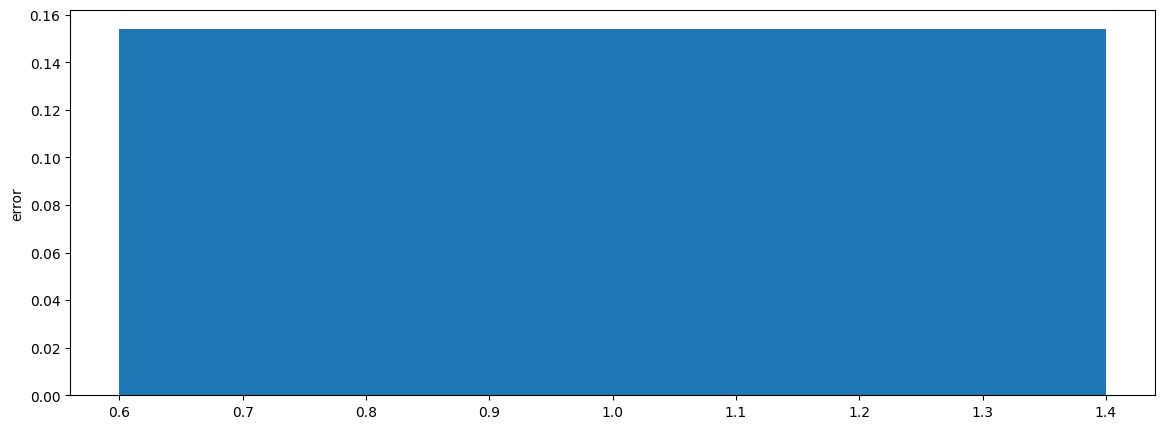

In [59]:
### PLOT RMSE ###

plt.figure(figsize=(14, 5))
plt.bar(1 ,error)
# plt.xticks(range(7), [str(s) for s in range(7)])
plt.ylabel("error")
np.set_printoptions(False)

In [62]:
def plot_predictions(y_true, y_pred, store, item):
    y_true = y_true.reshape(1, -1, unique_ids)
    y_pred = y_pred.reshape(1, -1, unique_ids)
    t = y_true[item, :, store]
    for i in range(unique_ids):

        plt.plot(y_true[item, :, store], label="true")
        plt.plot(y_pred[item, :, store], label="prediction")
        plt.title(f"store: {store} item: {item}")
        plt.legend()
        plt.ylabel("sales")
        plt.xlabel("date")

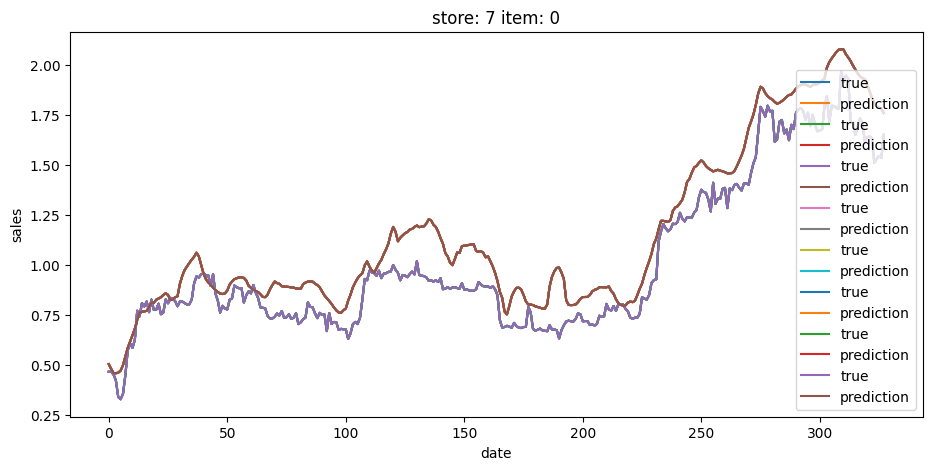

In [63]:
plt.figure(figsize=(11, 5))
plot_predictions(reverse_test, pred_test_all, unique_ids-1, 0)

In [64]:
y_true = np.sum(reverse_test, axis=1)
pred = np.sum(pred_test_all, axis=1)
unscaled_y_pred = scaler.inverse_transform([pred])[0]
unscaled_y_test = scaler.inverse_transform([y_true])[0]
pred

array([ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  5.,  5.,  5.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  7.,  7.,  7.,  7.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  8.,  8.,  8.,  8.,  8.,  9.,  9.,  8.,
        8.,  8.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  7.,  8.,  7.,  7.,  7.,  7.,  7.,
        7.,  7.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  7.,  7.,  7.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9., 10., 10., 10.,
       10., 10.,  9.,  9.,  9.,  9.,  9.,  9., 10., 10.,  9.,  9.,  8.,
        8.,  8.,  8.,  8.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,
        9.,  8.,  8.,  8.,  8.,  8.,  8.,  7.,  7.,  7.,  6.,  6.,  6.,
        6.,  7.,  7.,  8.,  8.,  8.,  7.,  7.,  6.,  6.,  6.,  6

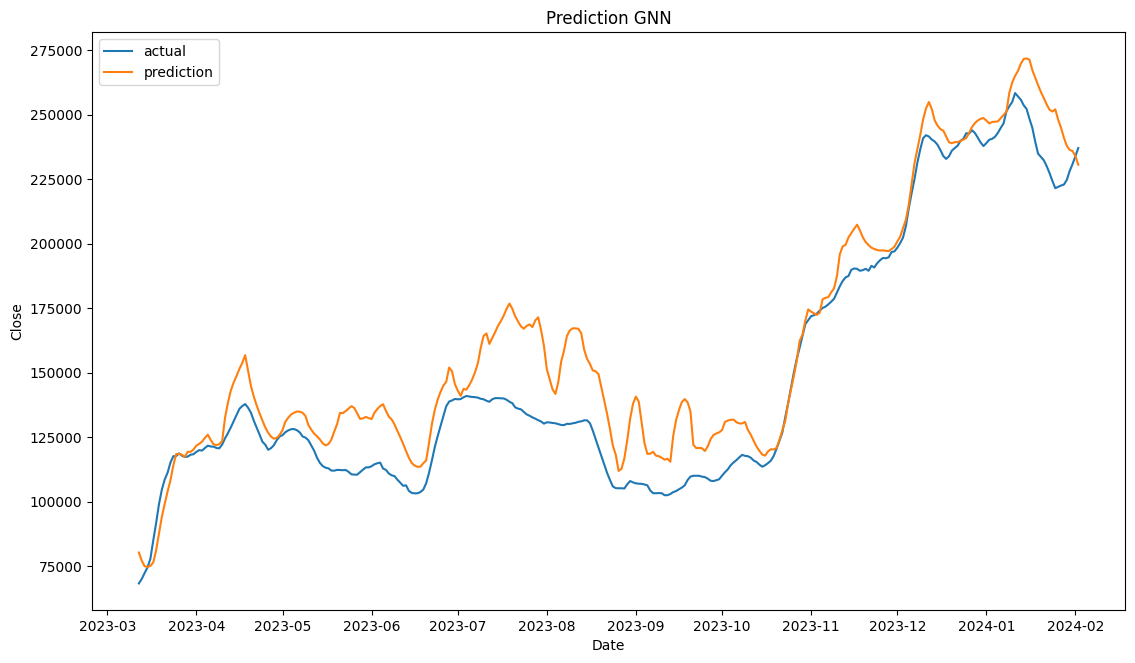

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(unique_dates[-len(unscaled_y_pred):], unscaled_y_test, label="actual")
ax.plot(unique_dates[-len(unscaled_y_pred):], unscaled_y_pred, label="prediction")
ax.set_title("Prediction GNN")
ax.set_ylabel("Close")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [66]:
from metrics import print_evaluation_metrics
print_evaluation_metrics(unscaled_y_pred, unscaled_y_test)


Evaluation Metrics:
MSE: 272953230.61
RMSE: 16521.30
MAE: 13113.13
MAPE: 10.03
SMAPE: 9.28
